<h1>Introduction</h1>
This Python3 notebook is used to generate most of the figures for the paper I am writing for Seismological Research Letters to describe capture, recovery and conversion of data from the Montserrat Volcano Observatory's analog seismic network (ASN) that was installed by the Volcano Disaster Assistance Program (VDAP) in 1995. Then ASN ran until December 2004 although the VDAP system was heavily modified on March 2nd, 2001, when PC-SEIS/XDETECT was swapped for the QNX/Seislog PC and BRAINS (SUDSPick, Hypo71) became obsolete.

<h1>Instructions:</h1>

<h3>Creation of CSVDB:</h3>
<ol>
    <li> cd to the root directory of this repo</li>
    <li>run BIN/seisanwavdb2csv.py. This will create any missing ASNE_wavefilesYYYYMM.csv files. These have one line for each trace in each wavfile.</li>
    <li>run count_traces_per_day.py. This will create ASNE_dailytraceid_wavfiles_df.csv. This has one line for each trace, every day. This is used to create the station and site on-time plots.</li>
</ol>
There can be missing days, where there was no data. This is what we use the fill_missing_days_in_df function for.

<h3>SUDS/Hypo71 to Seisan database conversion</h3>
Conversion of SUDS files to Miniseed, registering them into Seisan database in Nordic format (S-files), and then coverting PHA and PUN into Nordic format

<ol>
    <li>To learn how to convert a single event, use the vdap2seisanDB Python notebook. Each event must have either a WVM or DMX file (waveform data) and may also have a PHA file (phase pick readings) and a PUN file (Hypo71 summary file)</li>
    <li>To convert an entire collection of WVM, DMX, PHA and PUN files, use vdap2seisanDB.py.</li> 
    <li>A special version of this is montserrat_vdap2seisanDB.py, which has additional complexities in it unique to how the MVO data have been recovered and converted at different times.</li>
</ol>


<h3>Background:</h3>

ASN waveform data was converted 3 times:

    2001: 
    
    I had copies of IRIG.EXE, DEMUX.EXE from UEA Belham project I think?. and I modified sudsei.for from Seisan so that I could drive it from the command line. So I constructed Perl script to loop over all year/month directories of SUDS data, and time correct, demutiplex and convert to Seisan. I thought I even went through and associated all IRIG files into the MVOE database. I wonder where my original copy of the MVO REA/MVOE_ database went?
        
    2015:
        
    I used PC-SUDS or WIN-SUDS (which contained IRIG.EXE and DEMUX.EXE) and CONVSEIS (SUDS2GSE.EXE). So a Perl script on a 32-bit Windows PC was able to convert everything to GSE-1 format. And then I wrote ObsPy script to convert everything to Miniseed. Miniseed files were organized into an Antelope database, and then included when building an SDS archive of the combined networks.
    
    2019: 
    
    For the student project, I copied the ASN Miniseed event waveform data into a Seisan DB called ASNE. I also tested if conversion still worked, and on a 64-bit windows 10 laptop was able to run PC-SUDS DEMUX.EXE and SUD2MSED.EXE to convert some SUDS WVM to SUDS DMX and MiniSEED files.
    
    However, this was unsatisfying. So I decided to reconvert everything. I think this is in suds2seisandb.py and a similarly named notebook. I converted DMX files into SAC files and then into Miniseed files. If this did not work, I tried to find the corresponding GSE file from 2015 conversion. DMX and GSE files do not have any time conversions added, and I have not included any in the SAC or Miniseed version, so the ASNE_ Miniseed database on my Windows laptop is in exactly the same time zone as originally recorded. Was this recorded in local time (UTC - 4) or in UTC?

<i>Author: Glenn Thompson, 2019</i>

<h3>Issues discovered so far:</h3>

* Sometimes with ASN WAV files we noticed that 1 file comes 1-s after another. Probably registered twice? Need to eliminate the duplicates.

* The gaps in the WAV file ontime plot doesn't appear to correspond to the gaps found. Indeed, the gaps seem a lot less than show, e.g. early 2004.

* I do not have a copy of the IRIG Seisan DB, which I made at MVO. It sounds like BGS have a copy, from reading Richard Luckett's report. I believe this was all the data from XDETECT that I originally converted in 2001, after it was phased out.

* It appears that ASNE data (converted in 2015) are 4 hours behind SPN data (which we triggered in real-time by QNX, and appear to match DSN (MVO) data. This has only been seen in late March 2001 so far, which was after the transition. 

<b>Possibilities:</b>

1. All ASNE WAV files have a timestamp that is too great by 4 hours. This seems possible if a 4 hour time correction was ever applied during my 2015 conversions. Were XDETECT files were timestamped with UTC or local time? Logbooks likely matched. So they might all have been UTC! If I have inadvertently added 4 hours to all ASNE WAV files, this means that new S-files that students are generating are off by 4 hours also. This is the worst case scenario. But it is also possible that XDETECT used localtime, in which case I did need to apply a 4 hour correction. Could I have applied the time correction twice?

2. Only ASNE data after mid-March 2001 is off by 4 hours. I might have applied some blanket time correction to the data deriving from XDETECT (appropriate) and also from QNX Seislog (mistake). In this case I can probably throw away all ASN files after mid-March 2001 and use SPN files instead.



<h1><u>Read in libraries and define functions</u></h1>

In [1]:
import pandas as pd
import csv
import obspy
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime as dt

def get_yticks(thisdf):
    yticklabels = []
    yticks=[]
    i = 0
    for index, row in thisdf.iterrows():
        date = str(index)
        if date[-2:]=='01':
            yticklabels.append(date)
            yticks.append(i)
        i+=1
    ystep = 1
    if len(yticks)>15:
        ystep=2  
    if len(yticks)>25:
        ystep=3
    if len(yticks)>40:
        ystep=4
    if len(yticks)>60:
        ystep=6
    if len(yticks)>120:
        ystep=12    
    yticks = yticks[0::ystep]
    yticklabels = yticklabels[0::ystep]
    return (yticks, yticklabels)

def ontime_plot(data,xticklabels,yticks,yticklabels):
    # make ontime plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(data, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    ax.imshow(np.transpose(data), aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    #plt.xticks(np.arange(len(xticklabels)), xticklabels)
    plt.yticks(np.arange(len(xticklabels)), xticklabels)
    #ax.set_xticklabels(xticklabels, rotation = 90)
    ax.set_yticklabels(xticklabels, rotation = 0)
    #plt.yticks(yticks, yticklabels)
    plt.xticks(yticks, yticklabels, rotation = 90)
    plt.tight_layout()
    return (fig, ax)


def numrunningperday_plot_deprecated(data, yticks, yticklabels):
    fig = plt.figure()

    rect_main = [0.1, 0.1, 0.5, 0.75]
    rect_side = [0.7, 0.1, 0.2, 0.75]

    ax_main = plt.axes(rect_main)
    #ax1 = fig.add_subplot(121)
    s = np.sum(data,axis=1)
    ax_main.plot(s,'.',color='black',markersize=1)
    #plt.plot(s,'.',color='black',markersize=1)
    #plt.xticks(yticks, yticklabels)
    ax_main.set_xticks(yticks, yticklabels)
    #ax1.set_xticklabels(yticklabels, rotation = 90)
    ax_main.set_xticklabels(yticklabels, rotation = 90)
    #plt.ylabel('number\noperational')
    ax_main.set_ylabel('number\noperational')
    ax_main.tick_params(axis='both', which='major', labelsize=6)
    #plt.grid()
    ax_main.grid()
    fig.tight_layout()  

    ax_side = plt.axes(rect_side)
    binedges = np.arange(int(np.max(s))+2)-0.5
    #ax2 = fig.add_subplot(122)
    #plt.hist(s,bins=binedges,color='black',orientation='horizontal')
    ax_side.hist(s,bins=binedges,color='black',orientation='horizontal')
    return (fig, ax_main, s)

def numrunningperday_plot(data, yticks, yticklabels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = np.sum(data,axis=1)
    plt.plot(s,'.',color='black',markersize=0.1)
    plt.xticks(yticks, yticklabels)
    ax.set_xticks(yticks, yticklabels)
    ax.set_xticklabels(yticklabels, rotation = 90)
    ax.set_ylabel('number\noperational')
    #ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid()
    fig.tight_layout()  
    
    unique, counts = np.unique(s, return_counts=True)
    countsdf = pd.DataFrame(np.transpose([unique, counts]),columns=['numsites',"days"])
    numdays = countsdf['days'].sum()
    percent = countsdf['days']/numdays * 100
    countsdf['frequency']=percent
    print(countsdf)
    print('Total number of days is %.0f' % numdays)
    
    #ax_side.hist(s,bins=binedges,color='black',orientation='horizontal')
    return (fig, ax, s)

def intday2date(intday):
    ymd = str(intday)
    d = dt.date(int(ymd[0:4]),int(ymd[4:6]),int(ymd[6:8]))
    return d

def fill_missing_days_in_df(df, startday=19950726, endday=20041231):
    # need to make sure that every date from start to end exists in sites_df
    cols = list(df.columns)
    lastd = intday2date(startday)
    totalmissingdays = 0
    for index, row in df.iterrows():
        try:
            ymd = str(index)
        except:
            continue
        d = intday2date(ymd)
        daysdiff = (d-lastd).days
        if daysdiff > 1:
            totalmissingdays += daysdiff - 1
            print(daysdiff,' days missing between', lastd, ' and ', d)
            for d1 in range(1,daysdiff):
                missingday = lastd + dt.timedelta(days=d1)
                missingindex = int(missingday.strftime('%Y%m%d'))
                for col in cols:
                    df.at[missingindex,col]=0
                #missingdict = {'date':), \
                #    'BE':0, 'CP':0, 'GA':0, 'GH':0, 'GT':0, 'HR':0, 'JH':0, 'LG':0, \
                #    'LY':0, 'MVO':0, 'NEV':0, 'PL':0, 'RY':0, 'SA':0, 'SP':0, 'SS':0, \
                #    'VP':0, 'WH':0}
            #df = df.append(missingdict, ignore_index=True)
        lastd = d
    endd = intday2date(endday)   
    if lastd < endd:
        daysdiff = (endd-lastd).days
        for d1 in range(1,daysdiff+1):
            missingday = lastd + dt.timedelta(days=d1)
            missingindex = int(missingday.strftime('%Y%m%d'))
            for col in cols:
                df.at[missingindex,col]=0
    return(df.sort_index())

def translate_id2site(id):
    if len(id)==4:
        id = 'MV.%s' % id
    thissite = id[4:6]
    if id[3:7]=='LONG':
        thissite = 'LG'
    if id[3:5]=='MW':
        thissite = 'WH'
    if id[3:6]=='MVO':
        thissite = 'MVO'
    if id[4:7]=='NEV':
        thissite = 'NEV'
    if id[3:5]=='MP':
        thissite = 'PL'
    if id[3:6]=='MCH':
        thissite = 'CP'
    if id[3:6]=='MGT':
        thissite = 'GA'
    if id[3:7]=='IRIG' or id[3:7]=='TST1' or id[3:6]=='MRH':
        thissite = ''
    return thissite    

def stationids2sites(uniqids):
    sites = set()
    for id in uniqids:
        thissite = translate_id2site(id)
        if not thissite:
            continue
        sites.add(thissite)
    sites = sorted(sites)
    return sites

<h1><u>WAV files per day per station</u></h1>

Load in CSV file which has the number of events for each traceid each day<br/>
Columns are yyyymmdd traceid count

In [2]:
dailytraceidfile = 'DATA/ASNE_dailytraceid_wavfiles_df.csv'
trace_df = pd.read_csv(dailytraceidfile)
trace_df = trace_df[['yyyymmdd','traceid','count']]
trace_df = trace_df.set_index('yyyymmdd')
print(trace_df.head())
print(trace_df.tail())

                 traceid  count
yyyymmdd                       
19950701  MV.MVPZ.--.SHZ      0
19950701  MV.MWHE.--.SHE      0
19950701  MV.MCPT.--.SHZ      0
19950701  MV.MVOV.--.SHY      0
19950701  MV.MGAT.--.SHZ      0
                 traceid  count
yyyymmdd                       
20041231  MV.MWHN.--.SHX      0
20041231  MV.MHRE.--.SHX      0
20041231  MV.MPVE.--.SHZ      0
20041231  MV.MWHT.--.SHZ      0
20041231  MV.MPLX.--.SHE      0


In [3]:
uniqids = sorted(trace_df.traceid.unique())
station_ids = list(filter(lambda x: 'MV.M' in x, uniqids))
print(station_ids)

['MV.MBET.--.SHZ', 'MV.MCHT.--.SHZ', 'MV.MCPE.--.SHX', 'MV.MCPN.--.SHY', 'MV.MCPN.--.SHZ', 'MV.MCPT.--.SHZ', 'MV.MCPZ.--.SHY', 'MV.MCPZ.--.SHZ', 'MV.MGAT.--.SHZ', 'MV.MGHZ.--.SHZ', 'MV.MGT2.--.SHZ', 'MV.MHRE.--.SHX', 'MV.MHRE.--.SHZ', 'MV.MHRN.--.SHX', 'MV.MHRN.--.SHY', 'MV.MHRV.--.SHY', 'MV.MHRV.--.SHZ', 'MV.MJHL.--.SHZ', 'MV.MJHT.--.SHZ', 'MV.MLGL.--.SHE', 'MV.MLGL.--.SHZ', 'MV.MLGT.--.SHZ', 'MV.MLYT.--.SHZ', 'MV.MNEV.--.SHZ', 'MV.MPEW.--.SHE', 'MV.MPEW.--.SHZ', 'MV.MPLX.--.SHE', 'MV.MPLY.--.SHN', 'MV.MPLZ.--.SHZ', 'MV.MPNS.--.SHN', 'MV.MPVE.--.SHZ', 'MV.MRHT.--.SHZ', 'MV.MRYT.--.SHZ', 'MV.MSAT.--.SHZ', 'MV.MSPT.--.SHZ', 'MV.MSSE.--.SHX', 'MV.MSSN.--.SHY', 'MV.MSSZ.--.SHZ', 'MV.MVOE.--.SHZ', 'MV.MVON.--.SHX', 'MV.MVOV.--.SHY', 'MV.MVPE.--.SHE', 'MV.MVPE.--.SHX', 'MV.MVPN.--.SHY', 'MV.MVPV.--.SHZ', 'MV.MVPZ.--.SHZ', 'MV.MWEH.--.SHX', 'MV.MWEL.--.SHX', 'MV.MWH2.--.SHZ', 'MV.MWHE.--.SHE', 'MV.MWHE.--.SHX', 'MV.MWHE.--.SHY', 'MV.MWHN.--.SHN', 'MV.MWHN.--.SHX', 'MV.MWHN.--.SHY', 'MV.MWHT.

In [4]:
station_df = pd.DataFrame(columns = ['date'] + station_ids)
for index, row in trace_df.iterrows():
    #thisdate = row['yyyymmdd']
    thisdate = index
    thissta = row['traceid']
    thiscount = row['count']
    if np.isnan(thiscount):
        thiscount = 0
    station_df.at[thisdate,thissta] = thiscount
        
# Drop date column and fill missing days        
station_df = station_df.drop(columns=['date'])
station_df = fill_missing_days_in_df(station_df)

32  days missing between 2002-09-30  and  2002-11-01
31  days missing between 2003-03-31  and  2003-05-01


<h3>WAV file ontime per station</h3>

Text(6.8, 0.5, 'Station')

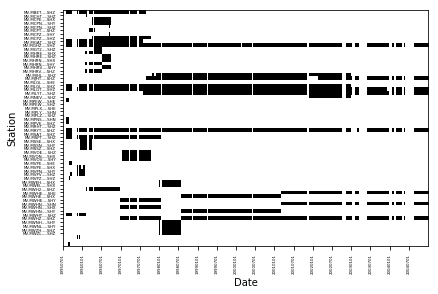

In [5]:
# Aren't these really independent NSLC's rather than just stations?
station_bool_df = (station_df > 0) * 1
station_bool_data = np.array(station_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = station_ids
(yticks, yticklabels) = get_yticks(station_bool_df)
(fig, ax) = ontime_plot(1-station_bool_data,xticklabels,yticks,yticklabels)
ax.tick_params(axis='both', which='major', labelsize=4)
fig.tight_layout()
plt.savefig('FIGURES/ASNE_station_ontime.pdf',dpi=300)
plt.xlabel('Date')
plt.ylabel('Station')

<h3>number of stations per day in WAV files</h3>

    numsites    days  frequency
0        0.0   550.0  15.841014
1        7.0    48.0   1.382488
2        8.0   413.0  11.895161
3        9.0    86.0   2.476959
4       10.0  1266.0  36.463134
5       11.0   390.0  11.232719
6       12.0    51.0   1.468894
7       13.0   189.0   5.443548
8       14.0   349.0  10.051843
9       15.0   125.0   3.600230
10      16.0     3.0   0.086406
11      17.0     2.0   0.057604
Total number of days is 3472


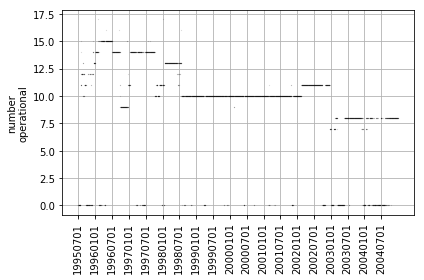

In [6]:
# So up to 17 channels. But mostly 10 (1266 days or 36.5%). 550 days with no data
(yticks, yticklabels) = get_yticks(station_bool_df)
(fig, ax, s) = numrunningperday_plot(station_bool_data, yticks, yticklabels)    
plt.savefig('FIGURES/ASNE_numstationsperday.pdf',dpi=300)

<h3>Histogram of how many stations operational per day in WAV files</h3>

Text(0, 0.5, 'Number of days')

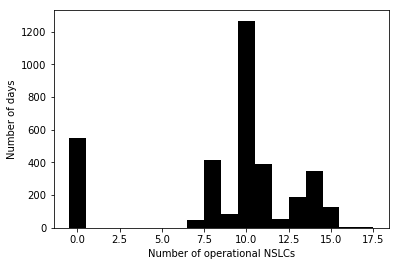

In [7]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(s,bins=binedges,color='black')
plt.xlabel('Number of operational NSLCs')
plt.ylabel('Number of days')

<h1><u>WAV file analysis by SITE</u></h1>
<h3>Convert WAV file data per station to per site</h3>
loop over rows in df, and create a new dataframe for sites, with a 1 to indicate if on for each day

In [8]:
uniqids = trace_df.traceid.unique()
sites = stationids2sites(uniqids)
sites_df = pd.DataFrame(columns = ['date'] + sorted(sites))
for index, row in trace_df.iterrows():
    #thisdate = row['yyyymmdd']
    thisdate = index
    thissite = translate_id2site(row['traceid'])
    if not thissite:
        continue
    thiscount = row['count']
    if np.isnan(thiscount):
        thiscount = 0
    currentcount = 0
    try:
        currentcount = sites_df.at[thisdate,thissite]
    except:
        pass
    if np.isnan(currentcount):
        currentcount = 0
    if thiscount > currentcount:
        sites_df.at[thisdate,thissite] = thiscount
        
# Drop date column and fill missing days        
sites_df = sites_df.drop(columns=['date'])
sites_df = fill_missing_days_in_df(sites_df)

19  days missing between 1995-09-22  and  1995-10-11
2  days missing between 1995-10-11  and  1995-10-13
4  days missing between 1995-10-13  and  1995-10-17
6  days missing between 1995-10-17  and  1995-10-23
15  days missing between 1995-10-23  and  1995-11-07
16  days missing between 1995-11-15  and  1995-12-01
2  days missing between 1996-02-06  and  1996-02-08
5  days missing between 1996-02-10  and  1996-02-15
8  days missing between 1996-02-15  and  1996-02-23
3  days missing between 1996-02-23  and  1996-02-26
2  days missing between 1996-02-26  and  1996-02-28
3  days missing between 1996-02-28  and  1996-03-02
2  days missing between 1996-03-03  and  1996-03-05
2  days missing between 1996-03-09  and  1996-03-11
2  days missing between 1996-03-11  and  1996-03-13
2  days missing between 1996-04-09  and  1996-04-11
9  days missing between 1996-04-11  and  1996-04-20
12  days missing between 1997-03-20  and  1997-04-01
3  days missing between 1997-05-01  and  1997-05-04
6  days 

<h3>WAV file ontime per site</h3>

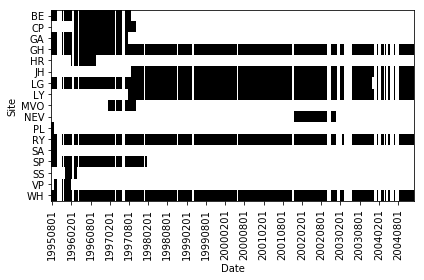

In [9]:
sites_bool_df = (sites_df > 0) * 1
sites_bool_data = np.array(sites_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = sites
(yticks, yticklabels) = get_yticks(sites_bool_df)
(fig, ax) = ontime_plot(1-sites_bool_data,xticklabels,yticks,yticklabels)
plt.xlabel('Date')
plt.ylabel('Site')
fig.tight_layout()  
plt.savefig('FIGURES/Figure7_ASNE_siteontime.pdf',dpi=300)

<h3>number of sites per day in WAV files</h3>

   numsites    days  frequency
0       0.0   524.0  15.206036
1       5.0    50.0   1.450958
2       6.0  1729.0  50.174115
3       7.0   464.0  13.464887
4       8.0   132.0   3.830528
5       9.0   510.0  14.799768
6      10.0    37.0   1.073709
Total number of days is 3446


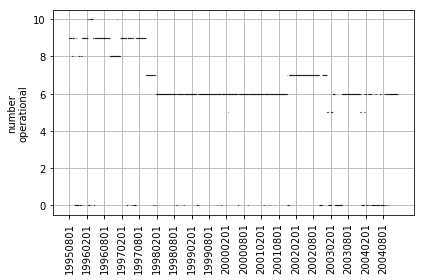

In [10]:
# 524 days with no data, that's 15.2% of the 3446 days.
# 6 sites was most common: 50.2% of the time (1729 days)
(fig, ax, s) = numrunningperday_plot(sites_bool_data, yticks, yticklabels)    
plt.savefig('FIGURES/Figure8_ASNE_numsitesperday.pdf',dpi=300)

<h3>Histogram of how many sites operational per day in WAV files</h3>

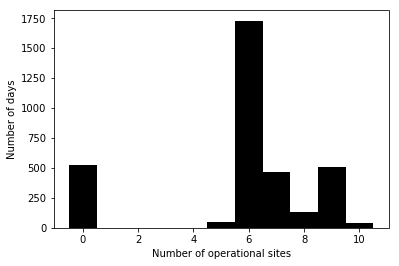

In [11]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(s,bins=binedges,color='black')
plt.xlabel('Number of operational sites')
plt.ylabel('Number of days')
plt.savefig('FIGURES/ASNE_sitesperday_histogram.pdf',dpi=300)

<h3>Number of WAV files per day</h3>
This is based on the 2015 conversion, as is everything above.

(3446, 17)
total # wavefiles = 230645


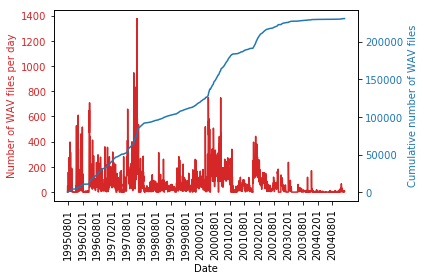

In [12]:
## This is a plot made from the 2015 ASNE_ database. It appears I had 230,645 files in that.
sites_data = np.array(sites_df) # convert dataframe to numpy array
print(sites_data.shape)
y = np.nanmax(sites_data,axis=1)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of WAV files per day', color=color)
ax1.plot(y, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(yticks, yticklabels)
ax1.set_xticklabels(yticklabels, rotation = 90)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cumulative number of WAV files', color=color)  # we already handled the x-label with ax1
ax2.plot(np.cumsum(y), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('FIGURES/ASNE_numwavfilesperday.png',dpi=300)
print('total # wavefiles = %d' % np.sum(y))

<h3>WAV files per day from WAV files on Windows laptop</h3>
This is the 2019 conversion.

We re-create the previous figure from the countWAVfilesperday.py script run on the latest ASNE_ Miniseed file Seisan DB on Windows laptop. This was last modified on 2019/12/16.

total # Miniseed files from 1995/07/27 to 2001/03/01 = 182388
total # missing Miniseed files from 1995/07/27 to 2001/03/01 = 11140
total # Seisan files from 2001/03/02 to 2004/12/16 = 47724
total # waveform files = 230112


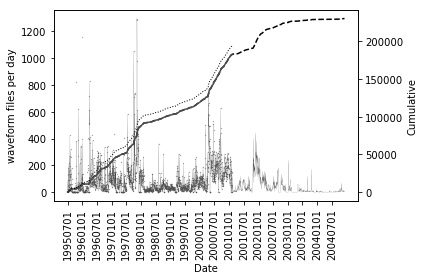

In [13]:
## This is a plot made from the 2019 ASNE_ database on the Windows laptop. This only goes to March 1st, 2001.
## so we append data from the 2015 ASNE_ database from March 2, 2001, which corresponds to SEISLOG system.
## We have only 230,112 files. Not sure why we are missing 533 files from the VDAP system period.
dailycounts_df = pd.read_csv('DATA/countWAVfiles.dat',delimiter=' ')
dailycounts_df['Date']
dateformatter = lambda x: x.replace('-','')
dailycounts_df['Date'] = dailycounts_df['Date'].apply(dateformatter)
dailycounts_df = dailycounts_df.set_index('Date')

plt.close('all')
#(yticks, yticklabels) = get_yticks(dailycounts_df)
(yticks, yticklabels) = get_yticks(station_bool_df)
y = dailycounts_df['Existing']
y2 = dailycounts_df['ShouldBe']
yall = np.nanmax(sites_data,axis=1)
yall[0:len(y)]=y
fig, ax1 = plt.subplots()
color1 = '0.0' # greyscale
color2 = '0.3'
ax1.set_xlabel('Date')
ax1.set_ylabel('waveform files per day', color=color1)
ax1.plot(range(len(yall)), yall, linewidth=0.1, color=color1)
ax1.plot(range(len(y2)), y2, 'o',  markersize=0.2,  color=color2)
#ax1.plot(range(len(y)), y, linewidth=0.2, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Cumulative', color=color1)  # we already handled the x-label with ax1
ax2.plot(np.cumsum(yall), '--', color=color1, linewidth=1.5)
ax2.plot(np.cumsum(y), color=color2, linewidth=1.5)
ax2.plot(np.cumsum(y2), color=color1, linestyle = ':', linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color1)

plt.xticks(yticks, yticklabels)
ax1.set_xticklabels(yticklabels, rotation = 90)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('FIGURES/Figure5_ASNEnumWaveformFilesPerDay_grey.pdf',dpi=300)
print('total # Miniseed files from 1995/07/27 to 2001/03/01 = %d' % np.sum(y))
print('total # missing Miniseed files from 1995/07/27 to 2001/03/01 = %d' % (np.sum(y2) - np.sum(y)) )
print('total # Seisan files from 2001/03/02 to 2004/12/16 = %d' % (np.sum(yall) - np.sum(y)))
print('total # waveform files = %d' % np.sum(yall))


# Evaluate the amount of RSAM data captured

RSAM_data_captured.m was written on iMac in Documents/MATLAB to make a summary of what fraction of RSAM data was collected for each station and for each day of the ASN. This generated files like RSAM_MBET.txt consisting of two columns: date (yyyymmdd) \t  MBET

Next we read in all these files, and create a dataframe from merging all of them

In [14]:
rsamtxtfiles = sorted(glob.glob('MATLAB/txtfiles/RSAM_????.txt'))
count = 0
for rsamfile in rsamtxtfiles:
    rsamdf=pd.read_csv(rsamfile,sep='\t')
    if count == 0:
        rsamdf_all = rsamdf
    else:
        rsamdf_all = pd.merge(rsamdf_all, rsamdf, on='date')
    count += 1
rsamdf_all = rsamdf_all.set_index('date')
print(rsamdf_all.head())
print(rsamdf_all.tail())
rsamdf_all = fill_missing_days_in_df(rsamdf_all, startday=19950728, endday=20040110)


          MBET  MCPT  MCPZ  MGAT  MGHZ  MHRE  MHRN  MHRV  MJHL  MJHT  ...  \
date                                                                  ...   
19950728  0.45   0.0   0.0  0.45  0.45   0.0   0.0   0.0   0.0   0.0  ...   
19950729  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...   
19950730  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...   
19950731  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...   
19950801  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...   

          MWEL  MWH2  MWHE  MWHN  MWHT  MWHZ  MWNH  MWNL  MWZH  MWZL  
date                                                                  
19950728   0.0   0.0   0.0   0.0  0.45   0.0   0.0   0.0   0.0   0.0  
19950729   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950730   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950731   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950801   0.0   0.0   0.0   0.0  

Create plots summarizing how much RSAM data captured

<h3>First examine RSAM data by station</h3>

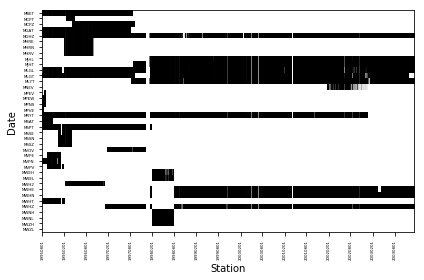

In [15]:
data_rsam = np.array(rsamdf_all, dtype=float) # convert dataframe to numpy array
xticklabels = rsamdf_all.columns
(yticks, yticklabels) = get_yticks(rsamdf_all)
(fig, ax) = ontime_plot(1-data_rsam,xticklabels,yticks,yticklabels)
ax.tick_params(axis='both', which='major', labelsize=4)
plt.ylabel('Date')
plt.xlabel('Station')
fig.tight_layout()
plt.savefig('FIGURES/RSAMontime.pdf',dpi=300)

    numsites  days  frequency
0          0    39   1.262545
1          4     2   0.064746
2          8   114   3.690515
3          9   480  15.539009
4         10  1488  48.170929
5         11   423  13.693752
6         12   401  12.981547
7         13    52   1.683393
8         14    37   1.197799
9         15    51   1.651020
10        16     2   0.064746
Total number of days is 3089


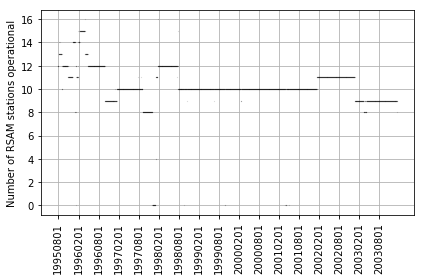

In [16]:
booldata_rsam = (data_rsam > 0) * 1
(fig, ax, s) = numrunningperday_plot(booldata_rsam, yticks, yticklabels)    
plt.ylabel('Number of RSAM stations operational')
fig.tight_layout()
plt.savefig('FIGURES/RSAM_numstationsperday.pdf',dpi=300)
#print(rsamdf_all.head())

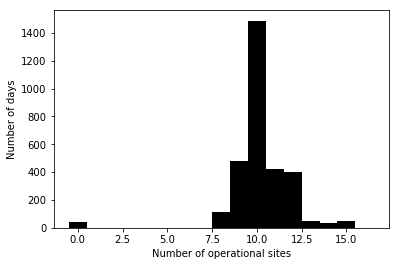

In [17]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(s,bins=binedges,color='black')
plt.xlabel('Number of operational sites')
plt.ylabel('Number of days')
plt.savefig('FIGURES/RSAM_numstationsperday_histogram.pdf',dpi=300)

<h3>Now examine RSAM data by site</h3>

In [18]:
rsamstations = list(xticklabels)
rsamsites = stationids2sites(rsamstations)
print(rsamsites)

['BE', 'CP', 'GA', 'GH', 'HR', 'JH', 'LG', 'LY', 'MVO', 'NEV', 'PL', 'RY', 'SA', 'SP', 'SS', 'VP', 'WH']


In [19]:
# loop over rows in df, and create a new dataframe for sites, with a 1 to indicate if on for each day
rsamsites_df = pd.DataFrame(columns = ['date'] + sorted(rsamsites))
for index, row in rsamdf_all.iterrows():
    for sta in rsamstations:
        thisdate = index #row['date']
        thissite = translate_id2site(sta)
        #print(sta,thissite)
        
        if not thissite:
            continue
        thiscount = row[sta]
        if np.isnan(thiscount):
            thiscount = 0
        currentcount = 0
        try:
            currentcount = rsamsites_df.at[thisdate,thissite]
        except:
            pass
        if np.isnan(currentcount):
            currentcount = 0
        if thiscount > currentcount:
            rsamsites_df.at[thisdate,thissite] = thiscount
rsamsites_df = fill_missing_days_in_df(rsamsites_df, startday=19950728, endday=20040110)
print(rsamsites_df)

2  days missing between 1996-01-10  and  1996-01-12
30  days missing between 1997-12-03  and  1998-01-02
2  days missing between 1998-09-20  and  1998-09-22
2  days missing between 1999-09-25  and  1999-09-27
2  days missing between 1999-09-28  and  1999-09-30
2  days missing between 2001-03-21  and  2001-03-23
5  days missing between 2001-03-29  and  2001-04-03
2  days missing between 2001-04-28  and  2001-04-30
         date    BE   CP    GA    GH   HR    JH    LG    LY  MVO  NEV    PL  \
19950728  NaN  0.45  NaN  0.45  0.45  NaN   NaN  0.45   NaN  NaN  NaN  0.45   
19950729  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950730  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950731  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950801  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
...       ...   ...  ...   ...   ...  ...   ...   ...   ...  ...  ...   ...   
20040106  NaN   NaN  NaN   NaN

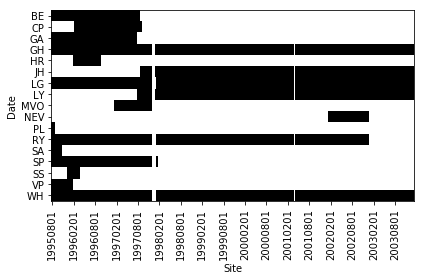

In [20]:
rsamsites_bool_df = (rsamsites_df > 0) * 1
data_rsam_sites = np.array(rsamsites_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = rsamsites
(yticks, yticklabels) = get_yticks(rsamsites_bool_df)
(fig, ax) = ontime_plot(1-data_rsam_sites[:,1:],xticklabels,yticks,yticklabels)
plt.ylabel('Date')
plt.xlabel('Site')
fig.tight_layout()
plt.savefig('FIGURES/RSAM_siteontime.pdf',dpi=300)

   numsites    days  frequency
0       0.0    39.0   1.262545
1       3.0     2.0   0.064746
2       5.0   391.0  12.657818
3       6.0  1441.0  46.649401
4       7.0   362.0  11.719003
5       8.0   241.0   7.801878
6       9.0   526.0  17.028164
7      10.0    87.0   2.816445
Total number of days is 3089


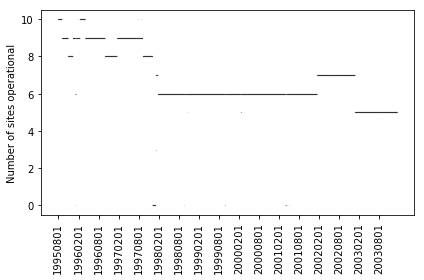

In [21]:
(fig, ax, srsam) = numrunningperday_plot(data_rsam_sites, yticks, yticklabels)    
plt.ylabel('Number of sites operational')
plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/RSAM_numsitesperday.pdf',dpi=300)

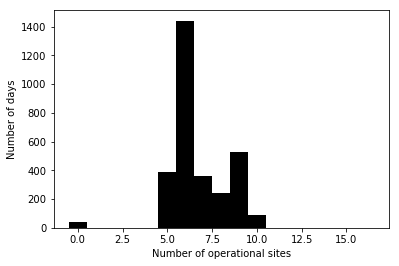

In [22]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(srsam,bins=binedges,color='black')
plt.xlabel('Number of operational sites')
plt.ylabel('Number of days')
plt.savefig('FIGURES/RSAM_numsitesperday_histogram.pdf',dpi=300)

<h1><u>Combined analysis of WAV files and RSAM 1-minute data</u></h1>

[[ 0.71428571  0.          0.71428571 ...,  0.          0.
   0.71428571]
 [ 1.          0.          1.         ...,  0.          0.28571429
   1.        ]
 [ 1.          0.          1.         ...,  0.          0.28571429
   1.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.
   0.71428571]
 [ 0.          0.          0.         ...,  0.          0.
   0.71428571]
 [ 0.          0.          0.         ...,  0.          0.
   0.71428571]]


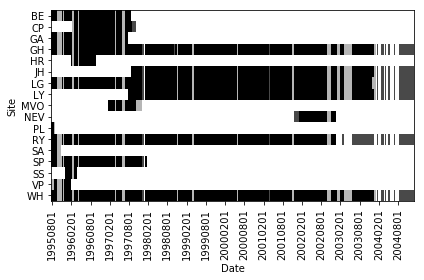

In [23]:
# Can we combine RSAM and WAV files continuous data into same time on?
xticklabels = sites
combined_df = sites_bool_df.add(rsamsites_bool_df*0.4, fill_value=0)
combined_df = combined_df.drop(columns='date')
#print(continuous_bool_df)
(yticks, yticklabels) = get_yticks(combined_df)
combined_data = np.array(combined_df, dtype=float)/1.4
print(combined_data)

(fig, ax) = ontime_plot(1-combined_data,xticklabels,yticks,yticklabels)
plt.xlabel('Date')
plt.ylabel('Site')
fig.tight_layout()  
plt.savefig('FIGURES/ASNE_siteontime_continuous.pdf',dpi=300)

   numsites  days  frequency
0         0   154   4.468950
1         5   175   5.078352
2         6  1814  52.640743
3         7   442  12.826465
4         8   206   5.977945
5         9   563  16.337783
6        10    92   2.669762
Total number of days is 3446


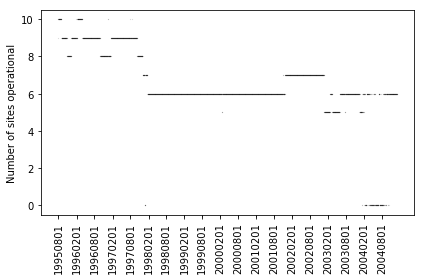

In [24]:
# Can we combine sites per day from events and RSAM?
combined_bool_data = (combined_data > 0) * 1
(fig, ax, scombined) = numrunningperday_plot(combined_bool_data, yticks, yticklabels)    
plt.ylabel('Number of sites operational')
plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/numsitesperday_combined.pdf',dpi=300)

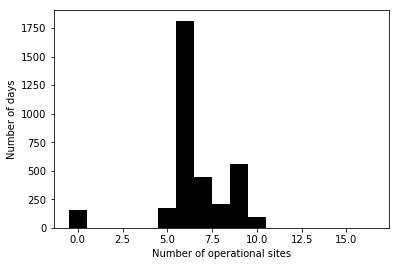

In [25]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(scombined,bins=binedges,color='black')
plt.xlabel('Number of operational sites')
plt.ylabel('Number of days')
plt.savefig('FIGURES/combined_numsitesperday_histogram.pdf',dpi=300)

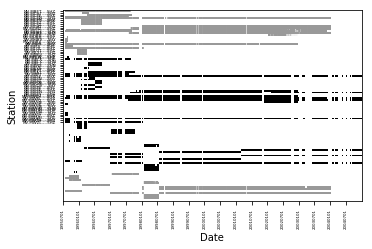

In [26]:
# Turns out we cannot combine them based on stations, because RSAM stations only record station code, whereas WAV files record whole NSLC
station_bool_df = (station_df > 0) * 1
station_bool_data = np.array(station_bool_df, dtype=float) # convert dataframe to numpy array
combined_station_df = station_bool_df.add(rsamdf_all*0.4, fill_value=0)
combined_station_data = np.array(combined_station_df, dtype=float)/1.4
(yticks, yticklabels) = get_yticks(combined_station_df)
xticklabels = station_ids
(fig, ax) = ontime_plot(1-combined_station_data,xticklabels,yticks,yticklabels)
plt.xlabel('Date')
plt.ylabel('Station')
fig.tight_layout()  
ax.tick_params(axis='both', which='major', labelsize=4)
# These do not combine as can be seen below

# TILT data analysis

In [27]:
tilttxtfiles = sorted(glob.glob('MATLAB/txtfiles/TILT_????.txt'))
count = 0
for tiltfile in tilttxtfiles:
    tiltdf=pd.read_csv(tiltfile,sep='\t')
    if count == 0:
        tiltdf_all = tiltdf
    else:
        tiltdf_all = pd.merge(tiltdf_all, tiltdf, on='date')
    count += 1
tiltdf_all = tiltdf_all.set_index('date')
print(tiltdf_all.head())
print(tiltdf_all.tail())
tiltdf_all = fill_missing_days_in_df(tiltdf_all, startday=19950727, endday=20001006)
tiltdf_all = tiltdf_all.drop(columns=['CENT'])


          AMER  CENT  CHP2  CHP3  CHPK  GAGE  HERM  LONG  PRNG
date                                                          
19950728  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.00
19950729  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.00
19950730  0.03   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.31
19950731  0.40   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.99
19950801  0.32   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.99
          AMER  CENT  CHP2  CHP3  CHPK  GAGE  HERM  LONG  PRNG
date                                                          
20040106   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040107   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040108   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040109   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040110   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


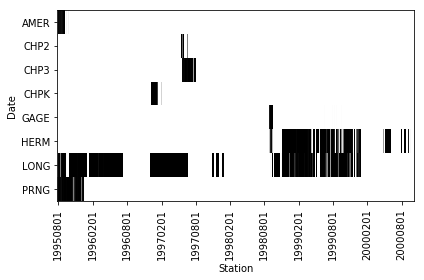

In [28]:
tiltdf_all = tiltdf_all[tiltdf_all.index <= 20001006] 
data_tilt = np.array(tiltdf_all, dtype=float) # convert dataframe to numpy array

xticklabels = tiltdf_all.columns
(yticks, yticklabels) = get_yticks(tiltdf_all)
(fig, ax) = ontime_plot(1-data_tilt,xticklabels,yticks,yticklabels)

plt.ylabel('Date')
plt.xlabel('Station')
fig.tight_layout()
plt.savefig('FIGURES/TILT_ontime.pdf',dpi=300)

   numsites  days  frequency
0         0   736  38.777661
1         1   531  27.976818
2         2   532  28.029505
3         3    99   5.216017
Total number of days is 1898


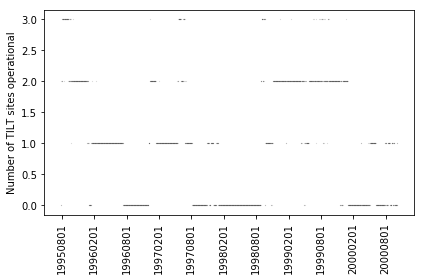

In [29]:
data_tilt_bool = np.round((data_tilt > 0)*1)
(fig, ax, stilt) = numrunningperday_plot(data_tilt_bool, yticks, yticklabels)    
plt.ylabel('Number of TILT sites operational')
plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/TILT_numsitesperday.pdf',dpi=300)

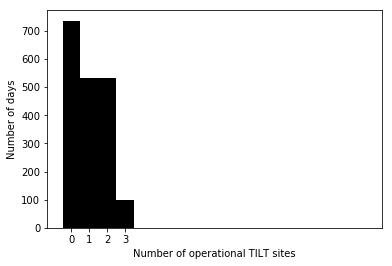

In [41]:
binedges = np.arange(int(np.max(s))+2)-0.5
plt.hist(stilt,bins=binedges,color='black')
plt.xlabel('Number of operational TILT sites')
plt.ylabel('Number of days')
plt.xticks([0, 1, 2, 3])
plt.savefig('FIGURES/TILT_numsitesperday_histogram.pdf',dpi=300)


<h1><u>Event counts, hypocenters and magnitudes</u></h1>

<h3>Read concatenated HYPO71 summary file into a DataFrame</h3>

In [31]:
hypodf = pd.DataFrame(columns=['otime','lat','lon','depth','mag'])
#summaryfile = '/Volumes/data/Montserrat/MASTERING/VDAP/Hypocentres/summaryall_plus_willy.txt'
summaryfile = 'DATA/summaryall_plus_willy.txt'
#summaryfile = '/Users/thompsong/Documents/MATLAB/gdrive/data/MVO/seismicdata/copied_to_newton/Hypocentres/summaryall.txt'
with open(summaryfile, 'r') as f1:
    for str in f1:
        try:
            yy = float(str[0:2].strip())
            mm = float(str[2:4].strip())
            dd = float(str[4:6].strip())
            hr = float(str[7:9].strip())
            mi = float(str[9:11].strip())
            secstr = str[12:17].strip()
            secstr=secstr.replace(':','.')
            sec = float(secstr.strip())
            lat = float(str[17:20].strip())
            mlat = float(str[21:26].strip())
            lon = float(str[27:30].strip())
            mlon = float(str[31:36].strip())
            depth = float(str[37:43].strip())
            magstr = str[45:49].strip()
        except:
            print('Failed on:')
            print(str)
            continue
        try:
            magstr = "%3.1f" % float(magstr)
        except:
            magstr = " " * 3
        nphase = float(str[50:53].strip())
        rms = float(str[62:66].strip())
        dlat = float(lat) + float(mlat)/60.0
        dlon = float(lon) + float(mlon)/60.0
        if yy < 80:
            cen = 20
        else:
            cen = 19
        if (sec<60.0):
            otime = dt.datetime(int(cen*100+yy),int(mm),int(dd),int(hr),int(mi),int(sec))
        else:
            otime = dt.datetime(int(cen*100+yy),int(mm),int(dd),int(hr),int(mi),0) + dt.timedelta(seconds=int(sec))
        newrow = {'otime':otime, 'lat':dlat, 'lon':dlon, 'depth':depth, 'mag':magstr}
        #print(newrow)
        hypodf = hypodf.append(newrow , ignore_index=True)
print(hypodf)

                    otime        lat        lon  depth  mag
0     2000-01-13 23:31:42  16.712167  62.175167   2.00     
1     2000-01-17 12:52:27  16.712833  62.175667   1.93     
2     2000-01-17 16:13:56  16.705000  62.174667   2.00     
3     2000-01-17 23:42:43  16.720000  62.178333   2.00     
4     2000-01-22 17:37:27  16.713500  62.175500   2.72  0.4
...                   ...        ...        ...    ...  ...
27626 1999-12-02 16:01:16  16.713000  62.175333   2.10  0.4
27627 1999-12-02 16:01:57  16.712333  62.175333   2.74  0.3
27628 1999-12-02 16:02:46  16.713500  62.175500   1.96  0.2
27629 1999-12-02 16:03:35  16.709833  62.176000   1.98     
27630 1999-12-07 22:26:37  16.729333  62.167333   2.28  1.1

[27631 rows x 5 columns]


<h3>Remove duplicate hypocenters</h3>

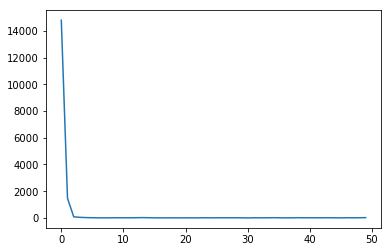

In [32]:
hypodf = hypodf.sort_values(by='otime')
x = hypodf.otime
la=dt.datetime(1990,1,1,0,0,0)
diffsecs = dt.timedelta(seconds=50)
i=0
secsdifflist = []
indexes = []
for a in x:
    secsdiff = a - la
    if secsdiff < diffsecs:
        secsdifflist.append(secsdiff.seconds)
    if secsdiff.seconds > 5:
        indexes.append(i)
    la=a
    i+=1
hypodf_duplicates_removed = hypodf.iloc[indexes]    
secsdifflist = np.array(sorted(secsdifflist))
values, counts = np.unique(secsdifflist, return_counts=True)
plt.plot(values, counts)

<h3>Plot cumulative hypocenters</h3>

/Users/thompsong/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


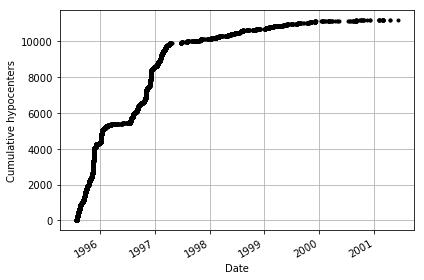

In [33]:
plt.close('all')
fig, ax1 = plt.subplots()
x = hypodf_duplicates_removed.otime
y = np.cumsum(np.ones((len(x), 1)))
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative hypocenters', color='black')
ax1.plot(x, y, '.', color='black', label='event alarms')
plt.gcf().autofmt_xdate()
plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/Hypocenters_timeseries.pdf',dpi=300)

<h3>Plot event counts, hypocenters and magnitudes</h3>

9325
total VTs: 36379
total LPs: 10499
total Hybrids: 45990
total Rockfalls: 58828
total Hypocenters: 11189
total Magnitudes: 9325


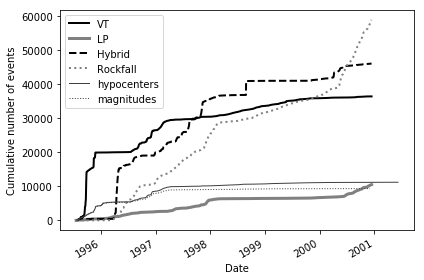

In [34]:
countsfile = 'MATLAB/spcounts_gt.csv'
countsdf = pd.read_csv(countsfile)
countsdf['date']=pd.Series([pd.to_datetime(date) for date in countsdf['date']])
countsdf = countsdf.fillna(0)

plt.close('all')
fig, ax1 = plt.subplots()
#x = countsdf.date
#lta=''
#i=0
#for a in x:
#    ta=type(a)
#    if ta!=lta:
#        print(ta)
#        print(i)
#    lta=ta
#    i+=1
#print(x)
# row 525 is bad
countsdf=countsdf.drop([525])
#print(countsdf.iloc[525])
x = countsdf.date

y = countsdf['volcano-tectonic'].apply(pd.to_numeric,errors='coerce')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative number of events', color='black')
ax1.plot(x, np.cumsum(y), color='black', label='VT', linewidth=2)
plt.gcf().autofmt_xdate()

y2 = countsdf['long-period'].apply(pd.to_numeric,errors='coerce')
ax1.plot(x, np.cumsum(y2), color='0.5', label='LP', linewidth=3)

y3 = countsdf['hybrid'].apply(pd.to_numeric,errors='coerce')
ax1.plot(x, np.cumsum(y3), '--', color='black', label='Hybrid', linewidth=2)

y4 = countsdf['rockfall'].apply(pd.to_numeric,errors='coerce')
ax1.plot(x, np.cumsum(y4), ':', color='0.5', label='Rockfall', linewidth=2)

x2 = hypodf_duplicates_removed.otime
y5 = np.ones((len(x2), 1))
#ax1.set_xlabel('Date')
#ax1.set_ylabel('Cumulative hypocenters', color='black')
ax1.plot(x2, np.cumsum(y5), color='0.25', label='hypocenters', linewidth=1)
#plt.gcf().autofmt_xdate()

# find hypocenters with magnitudes
c = 0
i = 0
ind = []
for mstr in hypodf_duplicates_removed.mag:
    try:
        m = float(mstr)
        c+=1
        ind.append(i)
    except:
        pass
    i+=1
print(c)
magdf = hypodf_duplicates_removed.iloc[ind]
x6 = magdf.otime
y6 = np.ones((len(x6), 1))

ax1.plot(x6, np.cumsum(y6), ':', color='0.25', label='magnitudes', linewidth=1)
ax1.legend()
fig.tight_layout()

print('total VTs: %d' % np.sum(y))
print('total LPs: %d' % np.sum(y2))
print('total Hybrids: %d' % np.sum(y3))
print('total Rockfalls: %d' % np.sum(y4))
print('total Hypocenters: %d' % np.sum(y5))
print('total Magnitudes: %d' % np.sum(y6))
plt.savefig('FIGURES/Figure6_eventcounts.pdf',dpi=300)

<h3>Gutenberg-Richter b-value plot</h3>

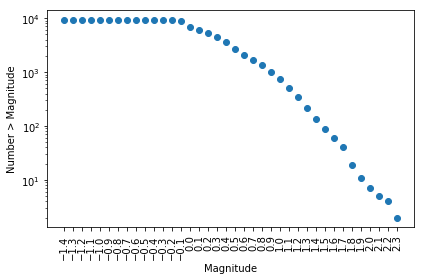

In [35]:
mags = []
for mag in sorted(magdf.mag):
    try:
        fmag = float(mag)
        mags.append(fmag)
    except:
        pass
mags = np.array(mags)
m_max = max(mags)
m_min = min(mags)
m = np.arange(m_min, m_max, 0.1)
n = np.zeros([len(m), 1])
i = 0
for thism in m:
    a = np.where(mags>thism)
    n[i] = len(a[0]) 
    i += 1
plt.semilogy(m, n, 'o')
plt.xticks(m, rotation = 90)
plt.xlabel('Magnitude')
plt.ylabel('Number > Magnitude')
plt.tight_layout()
plt.savefig('FIGURES/bvalues.pdf',dpi=300)

<h1><u>RSAM alarms</u></h1>

In [37]:
rsameventalarmsdf = pd.read_csv('DATA/rsam_events_alarms.csv')
rsameventalarmsdf.DATE = pd.Series([pd.to_datetime(date) for date in rsameventalarmsdf.DATE])
rsamtremoralarmsdf = pd.read_csv('DATA/rsam_tremor_alarms.csv')
rsamtremoralarmsdf.DATE = pd.Series([pd.to_datetime(date) for date in rsamtremoralarmsdf.DATE])

<h3>Cumulative numbers of alarms</h3>

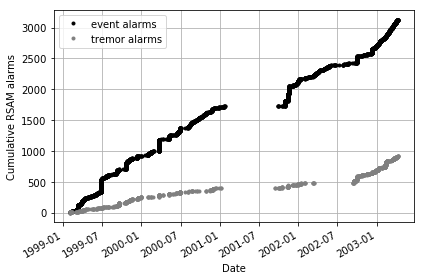

In [38]:
plt.close('all')
fig, ax1 = plt.subplots()
x = rsameventalarmsdf.DATE
y = np.cumsum(np.ones((len(x), 1)))
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative RSAM alarms', color='black')
ax1.plot(x, y, '.', color='black', label='event alarms')
plt.gcf().autofmt_xdate()

x2 = rsamtremoralarmsdf.DATE
y2 = np.cumsum(np.ones((len(x2), 1)))
ax1.plot(x2, y2, '.', color='gray', label='tremor alarms')

ax1.legend()

plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/RSAMalarms.pdf',dpi=300)

<h3>Cumulative RSAM amplitudes</h3>

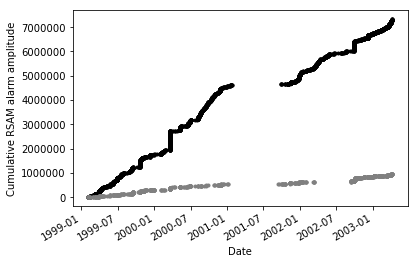

In [39]:
plt.close('all')
fig, ax1 = plt.subplots()
x = rsameventalarmsdf.DATE
y = rsameventalarmsdf['MLYT.DATA']+rsameventalarmsdf['MJHT.DATA']+ \
rsameventalarmsdf['MRYT.DATA']+rsameventalarmsdf['MLGT.DATA']+ \
rsameventalarmsdf['MWHZ.DATA']+rsameventalarmsdf['MGHZ.DATA']
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative RSAM alarm amplitude', color='black')
ax1.plot(x, np.cumsum(y), '.', color='black')
plt.gcf().autofmt_xdate()

x2 = rsamtremoralarmsdf.DATE
y2 = rsamtremoralarmsdf['MLYT.DATA']+rsamtremoralarmsdf['MJHT.DATA']+ \
rsamtremoralarmsdf['MRYT.DATA']+rsamtremoralarmsdf['MLGT.DATA']+ \
rsamtremoralarmsdf['MWHZ.DATA']+rsamtremoralarmsdf['MGHZ.DATA']
ax1.plot(x2, np.cumsum(y2), '.', color='gray')
plt.savefig('FIGURES/RSAMalarms_amplitudes.pdf',dpi=300)

<h3>Cumulative RSAM thresholds</h3>

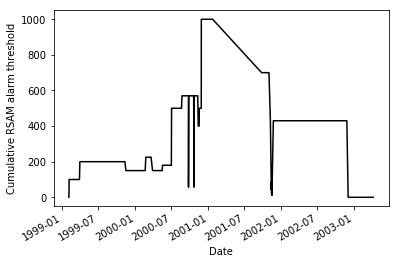

In [40]:
plt.close('all')
fig, ax1 = plt.subplots()
x = rsameventalarmsdf.DATE
# all stations
y = rsameventalarmsdf['MLYT.THRESH']+rsameventalarmsdf['MJHT.THRESH']+ \
rsameventalarmsdf['MRYT.THRESH']+rsameventalarmsdf['MLGT.THRESH']+ \
rsameventalarmsdf['MWHZ.THRESH']+rsameventalarmsdf['MGHZ.THRESH']
# one station
y = rsameventalarmsdf['MRYT.THRESH'] 
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative RSAM alarm threshold', color='black')
ax1.plot(x, y, color='black')
plt.gcf().autofmt_xdate()

# tremor alarms
#x2 = rsamtremoralarmsdf.DATE
#y2 = rsamtremoralarmsdf['MLYT.THRESH']+rsamtremoralarmsdf['MJHT.THRESH']+ \
#rsamtremoralarmsdf['MRYT.THRESH']+rsamtremoralarmsdf['MLGT.THRESH']+ \
#rsamtremoralarmsdf['MWHZ.THRESH']+rsamtremoralarmsdf['MGHZ.THRESH']
#y = rsamtremoralarmsdf['MLGT.THRESH']
#ax1.plot(x2, y2, color='gray')

plt.savefig('FIGURES/RSAMalarms_thresholds.pdf',dpi=300)

<h1><u>To do</u></h1>
<ul>
    <li>Number of classified events vs WAV files (possibly just July 1995 - October 1996)
    </li>
    </ul>
<h3>RSAM EVENTS, TRIGGERS AND SSAM DATA</h3>
<ul>
<li>cumulative RSAM events (or triggers?) vs day
<li>SSAM data
<li>How to associate RSAM triggers?
</ul>

<h3>DSN data</h3>

With the DSN data, we want to do similar things regarding DSNC_, BSAM and DSNE_ (MVOE_)

<h3>Merged data</h3>
<ul>
    <li>Minutes per day of data at each site?
    <li>got to merge the ASN and DSN catalogs properly
</ul>

In [42]:
2**23

8388608

In [43]:
11140/182388

0.06107857973112266

In [44]:
36379+45990+10499+58828

151696